# Identitas
**Nama: Alim Ikegami <br>
Username Dicoding: alimikegami <br>
Email: alimikegami1@gmail.com**

# **Mengunduh Dataset**

Tahapan pertama yang harus dilakukan sebelum membuat model adalah men-download dataset pada URL yang telah disediakan oleh pihak dicoding. Dataset akan diunduh dengan menggunakan perintah wget.

In [1]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

--2021-04-30 01:50:16--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/tmp/rockpaperscissors.zip’

/tmp/rockpapersciss 100%[===================>] 307.92M  9.04MB/s    in 43s     

2021-04-30 01:51:00 (7.14 MB/s) - ‘/tmp/rockpaperscissors.zip’ saved [322873683/322873683]



# **Mengekstraksi Dataset**


Setelah dataset diunduh, maka langkah selanjutnya adalah mengekstraksi dataset yang tersimpan pada direktori tmp dengan nama rockpaperscissors.zip dan meletakkan hasil ekstraksinya pada direktori tmp.

In [2]:
# Proses ekstraksi dataset

import zipfile
import os

zip_path = '/tmp/rockpaperscissors.zip'
zip_obj = zipfile.ZipFile(zip_path, 'r')
zip_obj.extractall('/tmp')
zip_obj.close()

In [3]:
# Proses split dataset menjadi 40% validasi 60% training

!pip install split-folders

import splitfolders
import os

'''
Yang di-split adalah direktori rps-cv-images karena apabila
dilakukan terhadap direktori rockpaperscissors akan terjadi error.
Error disebabkan oleh jumlah sampel yang dinilai kurang pada 
direktori rps-cv-images (mengandung 3 direktori & 1 file),
yang mana jumlah sampelnya minimum 100.
'''
splitfolders.ratio("/tmp/rockpaperscissors/rps-cv-images", output="/tmp/rps-images", seed=42, ratio=(0.6, 0.4))
base_data_dir = '/tmp/rps-images'
train_data_dir = os.path.join(base_data_dir, 'train')
validation_data_dir = os.path.join(base_data_dir, 'val')

Copying files: 2188 files [00:00, 3832.65 files/s]


In [4]:
'''
Menghitung jumlah data training dan validation
untuk memastikan data validation jumlahnya
40%
'''
jumlah_data_training = len(os.listdir(train_data_dir + '/paper')) + len(os.listdir(train_data_dir + '/rock')) + len(os.listdir(train_data_dir + '/scissors'))
jumlah_data_validation = len(os.listdir(validation_data_dir + '/paper')) + len(os.listdir(validation_data_dir + '/rock')) + len(os.listdir(validation_data_dir + '/scissors'))

jumlah_data = jumlah_data_training + jumlah_data_validation

print(f'Jumlah data training = {jumlah_data_training}')
print(f'Jumlah data validation = {jumlah_data_validation}')
print(f'Data training = {jumlah_data_training/jumlah_data}')
print(f'Data validation = {jumlah_data_validation/jumlah_data}')

Jumlah data training = 1312
Jumlah data validation = 876
Data training = 0.5996343692870201
Data validation = 0.40036563071297987


In [5]:
# memastikan bahwa telah terdapat 3 direktori yang memuat data dengan label yang berbeda
# pada direktori training

os.listdir(train_data_dir)

['scissors', 'paper', 'rock']

In [6]:
# memastikan bahwa telah terdapat 3 direktori yang memuat data dengan label yang berbeda
# pada direktori val (validation)

os.listdir(validation_data_dir)

['scissors', 'paper', 'rock']

# **Augmentasi data**

Selanjutnya, akan dilakukan persiapan terhadap dataset yang akan digunakan untuk melakukan training dan validation. Pada project atau submission ini, akan dilakukan data augmentation yang dapat memberikan tambahan variasi data pada gambar dengan melakukan berbagai operasi terhadap gambar tersebut seperti rotasi ataupun pembalikan (flipping). Proses augmentasi gambar dilakukan melalui **ImageDataGenerator** yang sekaligus dapat melabeli data.

In [7]:
# instansiasi objek ImageDataGenerator

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=25,
                    width_shift_range=0.1,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=25,
                    width_shift_range=0.1,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')                

In [8]:
# instansiasi objek generator yang akan
# melabeli data berdasarkan nama direktori

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical') # kelas lebih dari dua

validation_generator = validation_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(150, 150),
        batch_size=4,
        class_mode='categorical') # kelas lebih dari dua

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


# **Membangun CNN**

Selanjutnya, akan dilakukan pembangunan convolutional neural network yang akan digunakan untuk mengklasifikasikan gambar. Selain itu, dilakukan juga proses compile untuk menenetukan loss function dan optimizer yang digunakan beserta metrik yang akan dievaluasi dalam proses training. Optimizer yang digunakan adalah Adam yang umumnya dikenal sebagai optimizer dengan overall performance yang baik. Adam akan diberikan learning rate sebesar 0.001. Loss function yang akan digunakan adalah categorical cross entropy untuk mengklasifikasikan tiga kelas. Sedangkan, metrik yang akan dievaluasi adalah accuracy. 

In [9]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding="same", activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

# **Utility stuffs**

Pada section ini, terdapat beberapa hal yang digunakan untuk membantu penulis dalam menghitung waktu training serta membuat fungsi callback pada saat akurasi model telah mencapai lebih dari 97%

In [10]:
# Proses untuk mengunduh autotime
# autotime dapat memberikan jumlah waktu yang
# dihabiskan untuk mengeksekusi suatu cell

!pip install ipython-autotime
%load_ext autotime

time: 112 µs (started: 2021-04-30 01:51:14 +00:00)


In [11]:
# Fungsi untuk mengakhiri callback pada akhir epoch
'''
Callback akan dilakukan untuk menghentikan proses training ketika suatu akurasi
telah diperoleh. Pada project ini, penulis akan menghentikan training
ketika akurasi yang diperoleh telah melampaui 97% (alasan pemilihan 97%
adalah untuk memenuhi standar perolehan bintang 5, yaitu >96%). 
Dengan demikian, ketika akurasi tersebut telah diperoleh, 
maka training akan dihentikan agar waktu tidak terbuang sia-sia. 
'''

from tensorflow import keras

class CustomCallback(keras.callbacks.Callback):
  # fungsi akan dieksekusi di setiap akhir epoch
  def on_epoch_end(self, epoch, logs=None):
    if ((logs.get("accuracy") > 0.97) & (logs.get("val_accuracy") > 0.97)):
      print("Akurasi lebih besar dari 97%, training akan dihentikan untuk mempersingkat waktu")
      self.model.stop_training = True

time: 4.01 ms (started: 2021-04-30 01:51:14 +00:00)


#**Training model**

Pada section ini, akan dilakukan proses training.

In [12]:
# training model

history = model.fit(
      train_generator,
      steps_per_epoch=64,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=5,
      verbose=2,
      callbacks=[CustomCallback()])

Epoch 1/30
64/64 - 12s - loss: 1.1006 - accuracy: 0.3789 - val_loss: 1.1273 - val_accuracy: 0.2000
Epoch 2/30
64/64 - 11s - loss: 1.0617 - accuracy: 0.4180 - val_loss: 1.0523 - val_accuracy: 0.5000
Epoch 3/30
64/64 - 11s - loss: 0.9103 - accuracy: 0.5586 - val_loss: 0.5928 - val_accuracy: 0.8500
Epoch 4/30
64/64 - 11s - loss: 0.6947 - accuracy: 0.7305 - val_loss: 0.6703 - val_accuracy: 0.8000
Epoch 5/30
64/64 - 11s - loss: 0.5233 - accuracy: 0.8203 - val_loss: 0.5918 - val_accuracy: 0.7500
Epoch 6/30
64/64 - 11s - loss: 0.3306 - accuracy: 0.8828 - val_loss: 0.1774 - val_accuracy: 0.9500
Epoch 7/30
64/64 - 11s - loss: 0.3200 - accuracy: 0.8672 - val_loss: 0.2878 - val_accuracy: 0.9000
Epoch 8/30
64/64 - 11s - loss: 0.4037 - accuracy: 0.8750 - val_loss: 0.7289 - val_accuracy: 0.8500
Epoch 9/30
64/64 - 11s - loss: 0.2795 - accuracy: 0.8633 - val_loss: 0.1203 - val_accuracy: 0.9500
Epoch 10/30
64/64 - 11s - loss: 0.2504 - accuracy: 0.9258 - val_loss: 0.3661 - val_accuracy: 0.9000
Epoch 11/

# Plot accuracy dan loss

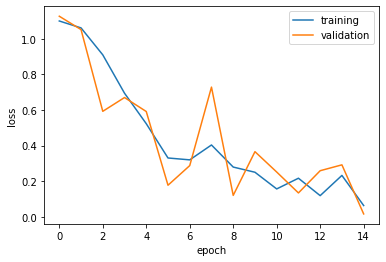

time: 200 ms (started: 2021-04-30 01:54:53 +00:00)


In [20]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
validation_loss = history.history['val_loss']
epoch = range(1, len(train_loss)+1)
plt.plot(train_loss)
plt.plot(validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'])


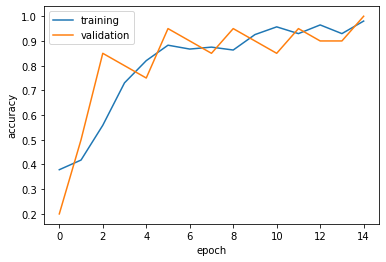

time: 263 ms (started: 2021-04-30 01:54:00 +00:00)


In [14]:
import matplotlib.pyplot as plt

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epoch = range(1, len(train_accuracy)+1)
plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['training', 'validation'])


# Uji Coba

In [15]:
from google.colab import files
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
 
 
def classify_image(image_data):
  for my_img in image_data.keys():
  
    img_path = my_img
    img = image.load_img(img_path, target_size=(150,150))
    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
  
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    
    print(my_img)

    if classes[0,0]==1:
      print('Paper')
    elif classes[0,1]==1:
      print('Rock')
    else:
      print('Scissor')

time: 77.3 ms (started: 2021-04-30 01:54:00 +00:00)


In [16]:
image_data = files.upload()

Saving QCHltvmva5vmGrPo.png to QCHltvmva5vmGrPo.png
time: 32.5 s (started: 2021-04-30 01:54:00 +00:00)


QCHltvmva5vmGrPo.png
Paper


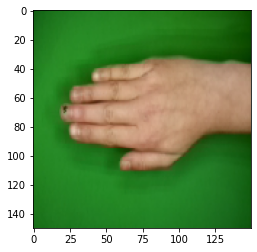

time: 334 ms (started: 2021-04-30 01:54:33 +00:00)


In [17]:
classify_image(image_data)

In [18]:
image_data = files.upload()

Saving UmpmKO5O9ku8kBwj.png to UmpmKO5O9ku8kBwj.png
time: 20 s (started: 2021-04-30 01:54:33 +00:00)


UmpmKO5O9ku8kBwj.png
Scissor


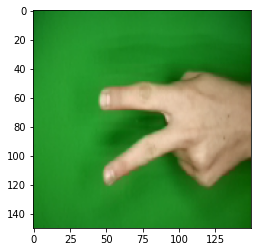

time: 235 ms (started: 2021-04-30 01:54:53 +00:00)


In [19]:
classify_image(image_data)